## DGA Detection Notebook

***Stage 0: Library Import***

Initial code block to import libraries

In [1]:
import io, os, sys, types, datetime, math, time, glob
from datetime import datetime, timedelta

import splunklib.client as client
import splunklib.results as results
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt 
%matplotlib inline


***Stage 1: Feature Engineering***

In this section we will be enriching our raw data with additional features that describe the domain name in more detail.

We will be accessing one of the lookup files that ships with the DGA App for Splunk (https://splunkbase.splunk.com/app/3559/) and do not need to query Splunk directly to access the data. Again note that you will need to substitute the path to the lookup file to work in your environment.

In [2]:
df=pd.read_csv("/path_to_splunk/Splunk/etc/apps/dga_analysis/lookups/dga_domains.csv")

This function cacluates the shannon entropy of the domain name - more reading here: https://arxiv.org/pdf/1405.2061.pdf#:~:text=At%20a%20conceptual%20level%2C%20Shannon's,of%20information%20in%20that%20variable.

In [3]:
# Enrich the data with the shannon entropy of the domain name

def shannon(word):
    entropy = 0.0
    length = len(word)

    occ = {}
    for ch in word:
        if ch in occ:
            occ[ch] += 1
        else:
            occ[ch] = 1

    for (k,v) in occ.items():
        p = float( v ) / float(length)
        entropy -= p * math.log(p, 2) # Log base 2
    
    return entropy

This next function calculates the vowel, consonant and numeric value ratio in the domain name

In [4]:
# Enrich the data with the vowel, consonant and numeric character ratios

def char_check(word):
    vowels=0
    consonants=0
    numbers=0
    length=len(word)
    
    for ch in word:
        if (ch=='A' or ch=='a' or ch=='E' or ch =='e' or ch=='I'
 or ch=='i' or ch=='O' or ch=='o' or ch=='U' or ch=='u'):
            vowels+=1
        elif ch.isalpha():
            consonants+=1
        elif ch.isnumeric():
            numbers+=1
    
    ratios=[vowels/length,consonants/length,numbers/length]
    
    return ratios

Using these functions we are going to enrich our orignal data to include the domain name length, the shannon entropy and the vowel, consonant and number ratios from the domain name

In [5]:
# Enrich the data with an additional column that describes the length of the domain
df['domain_length']=df.apply(lambda row: len(row.domain), axis=1)

# Calculate the entropy and ratios for the domain name   
shannon_entropy=list()
character_ratios=list()

for record in df['domain']:
    shannon_entropy.append(shannon(record))
    character_ratios.append(char_check(record))

# Enrich our data with the entropy
df["shannon_entropy"]=shannon_entropy

# Enrich our data with the character ratios
char_ratios=pd.DataFrame(character_ratios,columns=['vowel_ratio','consonant_ratio','number_ratio'])    
df=pd.concat([df,char_ratios],axis=1)

Next we are going to use TF-IDF to extract some of the key terms from across our corpus of domain names

In [6]:
# Train our TF-IDF Vectorizer
tfIdfVectorizer=TfidfVectorizer(analyzer='char',max_features=100,ngram_range=(2,3),use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(df['domain'])

# Create a data frame that describes the key terms in the set of domains and their likelihood
tfidf_df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)

# Use the key terms to set some output names
output_names=tfidf_df.index

# Transform the output data
output=tfIdf.toarray()

# Create a dataframe from the output data and output column names
tfidf_df_output = pd.DataFrame(output,columns=output_names)

# Enrich our data frame with the TF-IDF extractions
df=pd.concat([df,tfidf_df_output],axis=1)

Next we will use PCA to reduce our TF-IDF extractions into a set of 3 principal components

In [7]:
pca = PCA(n_components=3)
components=pca.fit_transform(tfidf_df_output)
principal_df = pd.DataFrame(data = components, columns = ['PC_1', 'PC_2','PC_3'])

df=pd.concat([df,principal_df],axis=1)

***Stage 2: Train and Test a Model***

In this final section we will be training a Random Forest Regressor to predict if a given domain name is legitimate or not.

In [8]:
# Set our variables to use in the model training and testing
target_variable=df['class']
feature_variables=df[['domain_length','shannon_entropy','vowel_ratio','consonant_ratio','number_ratio','PC_1','PC_2','PC_3']]

# Split into train and test datasets
feature_train, feature_test, target_train, target_test = train_test_split(feature_variables, target_variable, test_size=0.3, random_state=42)

# Train the random forest classifier
rfc=RandomForestClassifier(n_estimators=25)
rfc.fit(feature_train,target_train)

RandomForestClassifier(n_estimators=25)

Plot a confusion matrix that can be used to assess the accuracy of our predictions

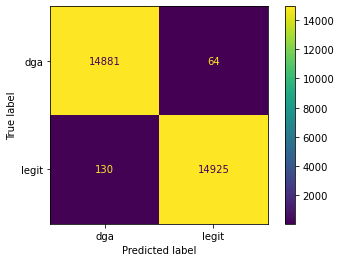

In [9]:
plot_confusion_matrix(rfc, feature_test, target_test)  
plt.show() 